# Test of pendulum Scinet with abnormal data

In [2]:
# Importations

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import gc
from tqdm import tqdm
from pathlib import Path

In [3]:
# Configurations

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Dependencies

from magnetics_diagnostic_analysis.project_scinet.setting_scinet import config

from magnetics_diagnostic_analysis.project_scinet.utils.data_creation_pendulum import data_synthetic_pendulum, plot_synthetic_pendulum
from magnetics_diagnostic_analysis.project_scinet.utils.build_dataset import build_dataset, PendulumDataset
from magnetics_diagnostic_analysis.project_scinet.utils.test_scinet import make_timeserie_prediction, plot_timeserie_prediction

from magnetics_diagnostic_analysis.project_scinet.model.scinet import PendulumNet
from magnetics_diagnostic_analysis.project_scinet.train_scinet import train_scinet

from magnetics_diagnostic_analysis.ml_tools.metrics import scinet_loss
from magnetics_diagnostic_analysis.ml_tools.train_callbacks import EarlyStopping, LRScheduling, GradientClipping


### 1. Create synthetic data & Add anomalies to thoose data

In [7]:
# Load datasets
path_train = config.DIR_SYNTHETIC_DATA / "pendulum_scinet_train.pt"
path_valid = config.DIR_SYNTHETIC_DATA / "pendulum_scinet_valid.pt"
train_dataset = torch.load(path_train)
valid_dataset = torch.load(path_valid)

/tmp/ipykernel_352561/1293850819.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_dataset = torch.load(path_train)
/tmp/ipykernel_352561/1293850819.py:5: FutureWarn

In [8]:
sample = train_dataset[0]
sample_observation = sample[0].numpy()
sample_question = sample[1].numpy()
sample_answer = sample[2].numpy()
sample_params = sample[3].numpy()

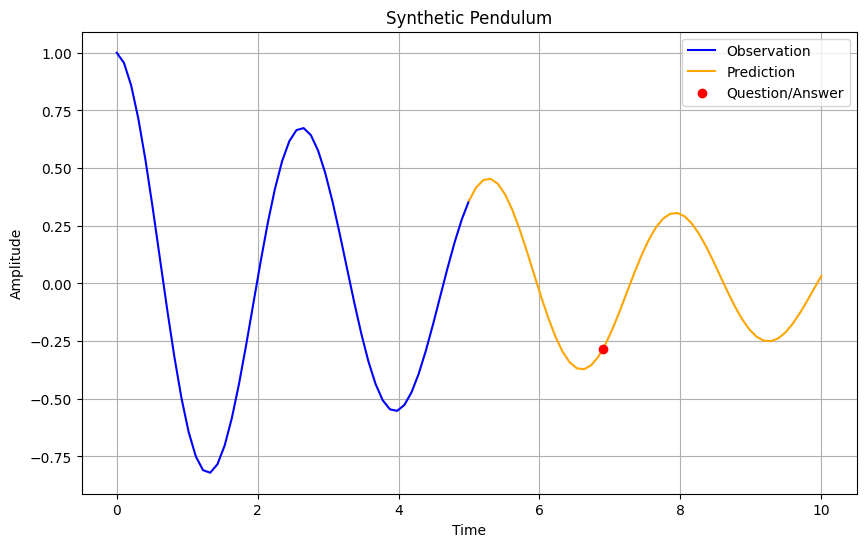

In [9]:
def plot_synthetic_pendulum(timeserie, timeserienext, question, answer, timesteps=50, maxtime=5.0):
    t = np.linspace(0, maxtime, timesteps)
    tnext = np.linspace(maxtime, maxtime*2, timesteps)
    plt.figure(figsize=(10, 6))
    plt.plot(t, timeserie, label='Observation', color='blue')
    plt.plot(tnext, timeserienext, label='Prediction', color='orange')
    plt.scatter(question, answer, color='red', label='Question/Answer', zorder=5)
    plt.title(f'Synthetic Pendulum')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.legend()
    plt.show()

plot_synthetic_pendulum(
    timeserie=sample_observation,
    timeserienext=data_synthetic_pendulum(sample_params[0], sample_params[1], t=np.linspace(config.MAXTIME, config.MAXTIME*2, config.TIMESTEPS)),
    question=sample_question,
    answer=sample_answer
)

In [10]:
def create_anomaly(data, start_index=100,  duration=60, intensity=0.5):
    base_value = data[start_index]
    data[start_index:start_index + duration] = base_value + intensity * np.random.normal(loc=0, scale=0.8, size=duration)

In [11]:
create_anomaly(sample_observation,  start_index=10,  duration=5, intensity=0.3)
create_anomaly(sample_observation,  start_index=35,  duration=10, intensity=0.3)

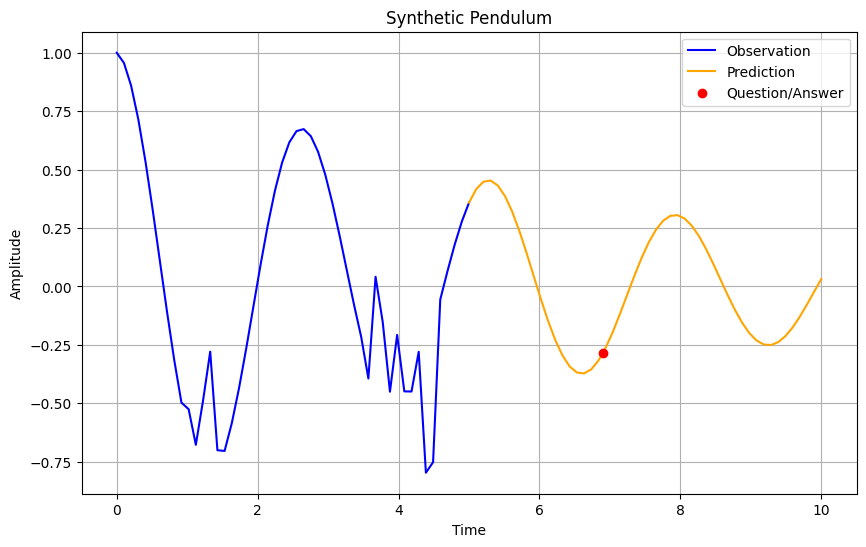

In [12]:
plot_synthetic_pendulum(
    timeserie=sample_observation,
    timeserienext=data_synthetic_pendulum(sample_params[0], sample_params[1], t=np.linspace(config.MAXTIME, config.MAXTIME*2, config.TIMESTEPS)),
    question=sample_question,
    answer=sample_answer
)

In [13]:
def create_one_anomaly(data, anomaly_type, seed=None, **ano_args):

    """
    ano_args should contain:
    - if 'spike':
                    start_index, intensity
    - if 'noise':
                    start_index, duration, instensity
    - if 'drift+overflow':
                    slope, value_upper, value_lower
    - if 'level_shift':
                    start_index, shift_value
    - if 'seasonal_break':
                    start_index, duration
    """

    if seed is not None:
        np.random.seed(seed)
    
    data_with_anomalies = data.copy()
    n_timesteps = len(data)
    anomaly_info = []

    if anomaly_type == 'spike':
        assert 'start_index' in ano_args and 'intensity' in ano_args, "Missing arguments for spike anomaly"
        assert 0 <= ano_args['start_index'] < n_timesteps-3, "start_index out of bounds"

        spiked_signal = np.zeros_like(data_with_anomalies)
        start_anomaly = ano_args['start_index']
        spiked_signal[start_anomaly : start_anomaly+3] = np.random.choice([-1, 1]) * np.array([0.7, 1.0, 0.7]) * ano_args['intensity'] * np.std(data)
        data_with_anomalies += spiked_signal

    elif anomaly_type == 'noise':
        assert 'start_index' in ano_args and 'duration' in ano_args and 'intensity' in ano_args, "Missing arguments for noise anomaly"
        assert 0 <= ano_args['start_index'] < n_timesteps-ano_args['duration'], "start_index out of bounds"

        noised_signal = np.zeros_like(data_with_anomalies)
        window_size = min(100, ano_args['start_index'])
        local_std = np.std(data[max(0, ano_args['start_index']-window_size):ano_args['start_index']]) if window_size > 0 else np.std(data)
        noise_amp = ano_args['intensity'] * local_std
        noise = np.random.normal(0, noise_amp, size=ano_args['duration'])
        noised_signal[ano_args['start_index'] : ano_args['start_index']+ano_args['duration']] += noise
        data_with_anomalies += noised_signal

    elif anomaly_type == 'drift+overflow':
        assert 'slope' in ano_args and 'value_upper' in ano_args and 'value_lower' in ano_args, "Missing arguments for drift anomaly"
        assert abs(ano_args['slope']) > 1.0e-4, "Slope must be non-zero for drift anomaly"

        drifted_signal = np.arange(0, n_timesteps) * ano_args['slope']
        data_drifted = data_with_anomalies + drifted_signal
        if ano_args['value_upper'] is not None and ano_args['value_lower'] is not None:
            if ano_args['slope'] > 0:
                for i in range(n_timesteps):
                    if data_drifted[i] > ano_args['value_upper']:
                        data_drifted[i:] = data_drifted[i:] - (ano_args['value_upper'] - ano_args['value_lower'])
            elif ano_args['slope'] < 0:
                for i in range(n_timesteps):
                    if data_drifted[i] < ano_args['value_lower']:
                        data_drifted[i:] = data_drifted[i:] - (ano_args['value_lower'] - ano_args['value_upper'])
        data_with_anomalies = data_drifted

    elif anomaly_type == 'level_shift':
        assert 'start_index' in ano_args and 'shift_value' in ano_args, "Missing arguments for level shift anomaly"

        shifted_signal = np.zeros_like(data_with_anomalies)
        shifted_signal[ano_args['start_index']:] = ano_args['shift_value']
        data_with_anomalies += shifted_signal

    elif anomaly_type == 'seasonal_break':
        assert 'start_index' in ano_args and 'duration' in ano_args, "Missing arguments for seasonal break anomaly"

        period = np.zeros_like(data_with_anomalies)
        period[ano_args['start_index']:ano_args['start_index']+ano_args['duration']] = data[ano_args['start_index']:ano_args['start_index']+ano_args['duration']]
        data_with_anomalies -= period

    anomaly_info.append({
        'type': anomaly_type,
        'ano_args': ano_args
    })

    return data_with_anomalies, anomaly_info

In [16]:
kapa = 5
b = 0.5
max_time, timesteps = 15.0, 150
time = np.linspace(0, max_time, timesteps)
data_pendulum = data_synthetic_pendulum(kapa, b, t=time)

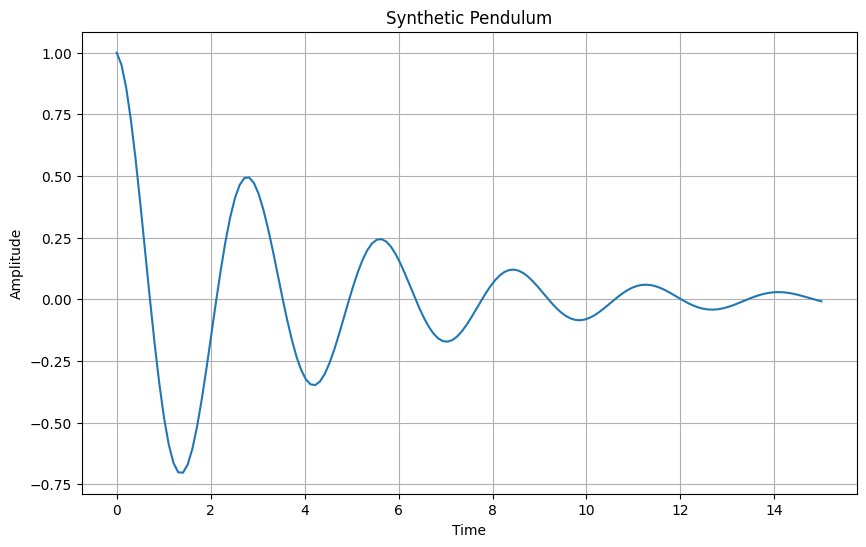

In [17]:
def plot_synthetic_pendulum(timeserie, timesteps=150, maxtime=15.0):
    t = np.linspace(0, maxtime, timesteps)
    y = timeserie
    plt.figure(figsize=(10, 6))
    plt.plot(t, y)
    plt.title(f'Synthetic Pendulum')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()
plot_synthetic_pendulum(data_pendulum, timesteps=timesteps, maxtime=max_time)

#### Test anomaly: spike

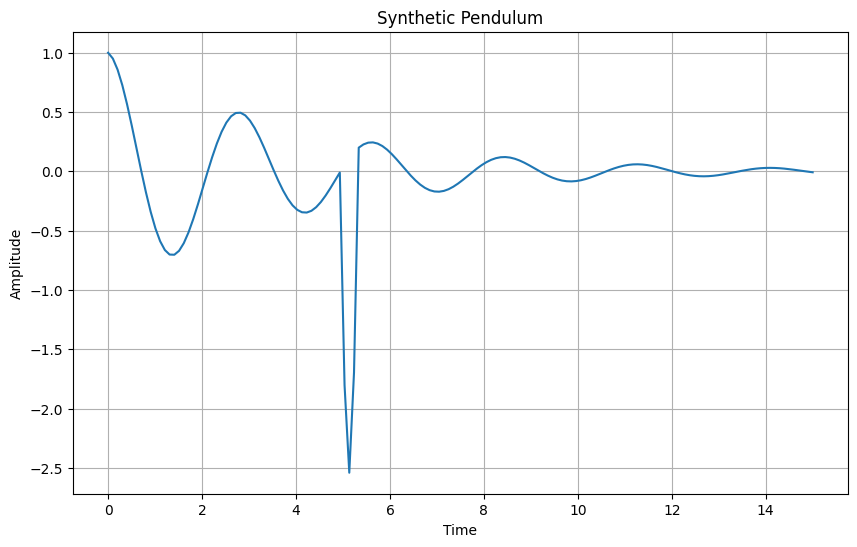

In [18]:
data_pendulum_spike, info_spike = create_one_anomaly(data_pendulum, 'spike', seed=None, start_index=50, intensity=10)
plot_synthetic_pendulum(data_pendulum_spike, timesteps=timesteps, maxtime=max_time)

#### Test anomaly: noise

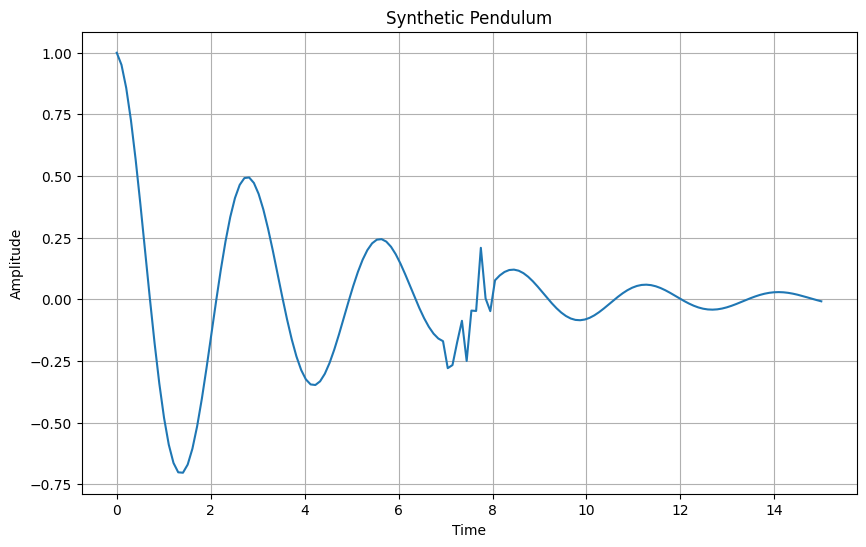

In [19]:
data_pendulum_noise, info_noise = create_one_anomaly(data_pendulum, 'noise', seed=None, start_index=70, duration=10, intensity=0.5)
plot_synthetic_pendulum(data_pendulum_noise, timesteps=timesteps, maxtime=max_time)

#### Test anomaly: drift+overflow

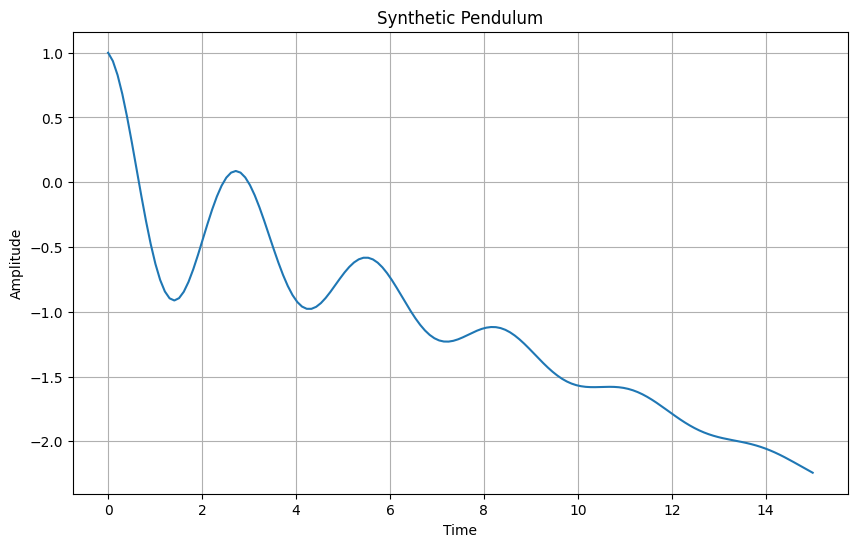

In [20]:
data_pendulum_drift, info_drift = create_one_anomaly(data_pendulum, 'drift+overflow', seed=None, slope=-0.015, value_upper=None, value_lower=None)
plot_synthetic_pendulum(data_pendulum_drift, timesteps=timesteps, maxtime=max_time)

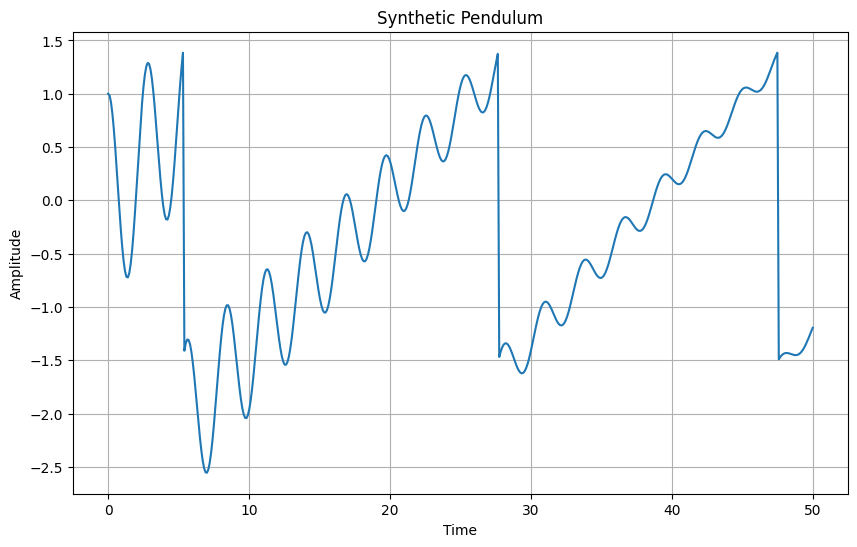

In [23]:
kapa2 = 5
b2 = 0.1
max_time2, timesteps2 = 50.0, 500
time2 = np.linspace(0, max_time2, timesteps2)
data_pendulum2 = data_synthetic_pendulum(kapa2, b2, t=time2)

data_pendulum_drift2, info_drift2 = create_one_anomaly(data_pendulum2, 'drift+overflow', seed=None, slope=0.015, value_upper=1.4, value_lower=-1.5)
plot_synthetic_pendulum(data_pendulum_drift2, timesteps=timesteps2, maxtime=max_time2)

#### Test anomaly: level_shift

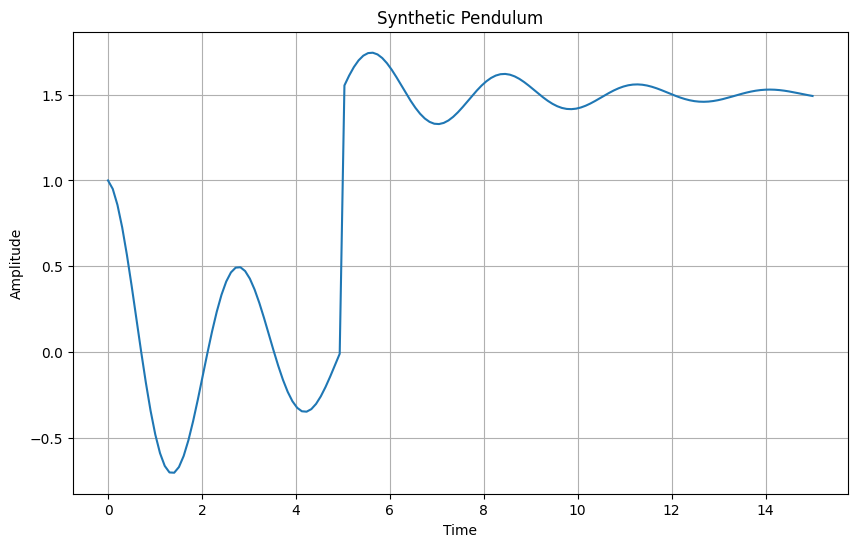

In [131]:
data_pendulum_shift, info_shift = create_one_anomaly(data_pendulum, 'level_shift', seed=None, start_index=50, shift_value=1.5)
plot_synthetic_pendulum(data_pendulum_shift, timesteps=timesteps, maxtime=max_time)

#### Test anomaly: seasonal_break

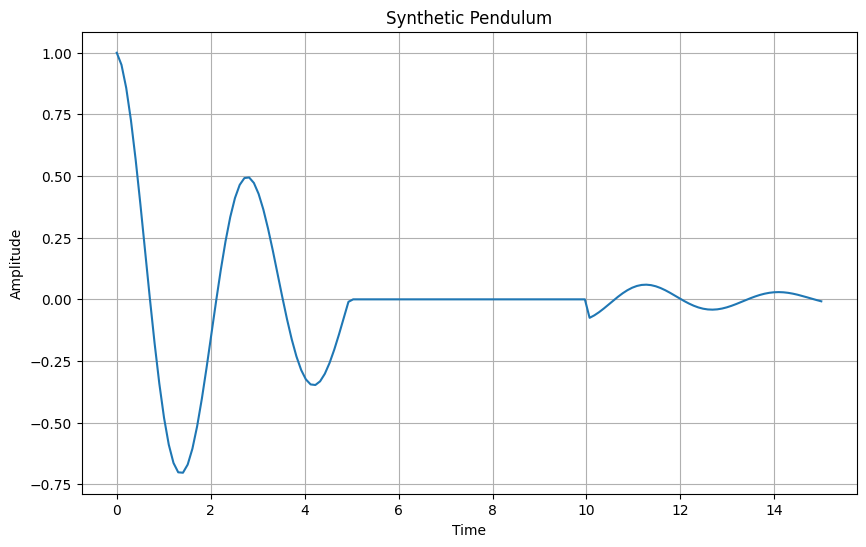

In [135]:
data_pendulum_break, info_break = create_one_anomaly(data_pendulum, 'seasonal_break', seed=None, start_index=50, duration=50)
plot_synthetic_pendulum(data_pendulum_break, timesteps=timesteps, maxtime=max_time)

## Test SciNet with abnormal observations

### Create a test set full of anomalies

In [286]:
def load_trained_model(model_path: str, device: torch.device = torch.device('cpu')) -> PendulumNet:
    model = PendulumNet(
        input_size=config.M_INPUT_SIZE,
        enc_hidden_sizes=config.M_ENC_HIDDEN_SIZES,
        latent_size=config.M_LATENT_SIZE,
        question_size=config.M_QUESTION_SIZE,
        dec_hidden_sizes=config.M_DEC_HIDDEN_SIZES,
        output_size=config.M_OUTPUT_SIZE
    )
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

In [287]:
device = config.DEVICE
path = config.DIR_MODEL_PARAMS / f"{config.BEST_MODEL_NAME}.pth"
#path = config.DIR_MODEL_PARAMS / f"pendulum_scinet1.pth"
pendulum_net = load_trained_model(path, device=device)

/tmp/ipykernel_1465729/497590948.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


In [288]:
def make_timeserie_prediction(model: nn.Module, observation: np.array, questions: np.array, device: torch.device = torch.device('cpu')) -> float:
    torch.cuda.empty_cache()
    model.to(device).eval()
    observation_tensor = torch.tensor(observation, dtype=torch.float32).unsqueeze(0).to(device)
    possible_answers = []
    with torch.no_grad():
        for q in questions:
            question_tensor = torch.tensor(q, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
            possible_answer, _, _ = model(observation_tensor, question_tensor)
            possible_answers.append(possible_answer.item())
    return np.array(possible_answers)

def plot_timeserie_prediction(observations, answers, possible_answers, maxtime, timesteps) -> None:
    fig = plt.figure(figsize=(10, 6))
    time = np.linspace(0, maxtime, timesteps)
    time_next = np.linspace(maxtime, maxtime*2, timesteps)
    time_full = np.linspace(0, maxtime*2, timesteps)
    plt.plot(time, observations, label='Observation', color='blue')
    plt.plot(time_next, answers, label='Unseen future', color='green')
    plt.plot(time_full, possible_answers, label='Prediction', color='red')
    plt.title('Pendulum Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()
    plt.show() 
    return None


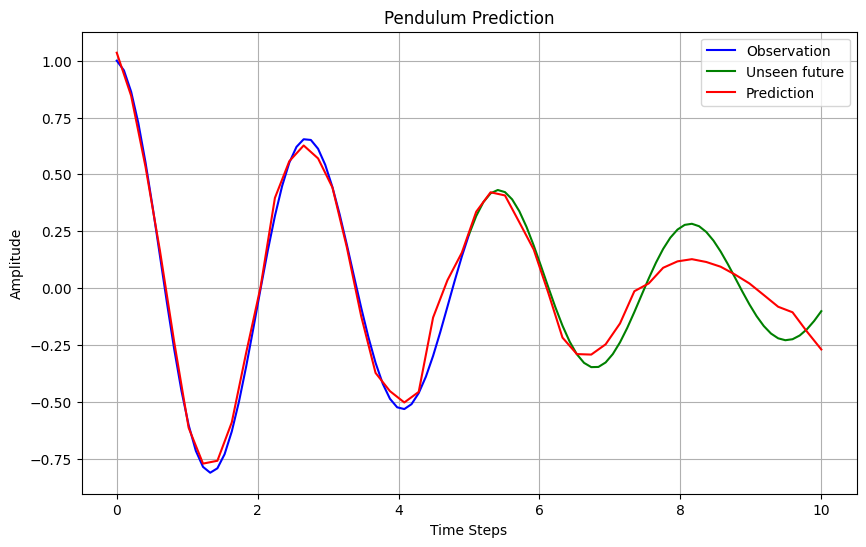

In [289]:
# normal datat = no anomaly

N_samples = 1
observations, _, _, params = build_dataset(N_samples, config.KAPA_RANGE, config.B_RANGE)
answers = data_synthetic_pendulum(params[0][0], params[0][1], t=np.linspace(config.MAXTIME, config.MAXTIME*2, config.TIMESTEPS))

questions = np.linspace(0, config.MAXTIME*2, config.TIMESTEPS)
possible_answers = make_timeserie_prediction(pendulum_net, observations[0], questions, device=device)
plot_timeserie_prediction(observations[0], answers, possible_answers, maxtime=config.MAXTIME, timesteps=config.TIMESTEPS)

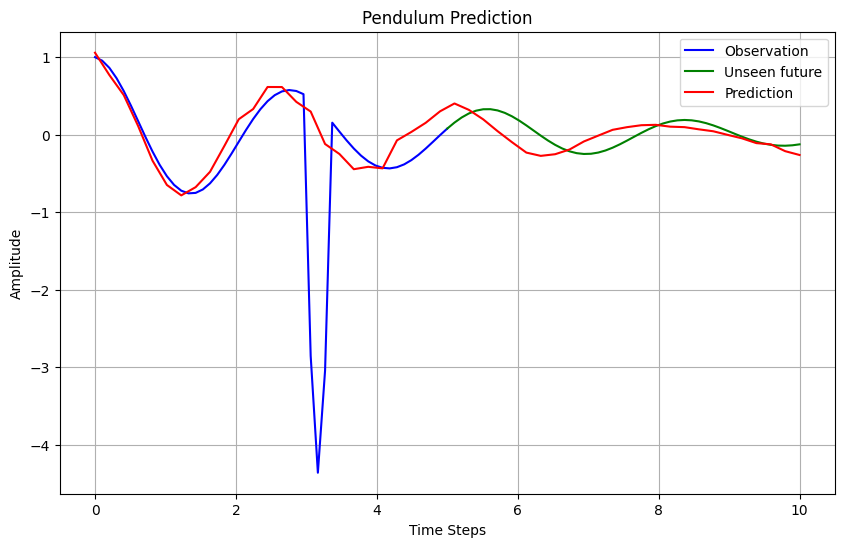

In [290]:
# Spiked data

N_samples = 1
observations, _, _, params = build_dataset(N_samples, config.KAPA_RANGE, config.B_RANGE)
observation_piked = create_one_anomaly(observations[0], 'spike', seed=None, start_index=30, intensity=10)[0]
answers = data_synthetic_pendulum(params[0][0], params[0][1], t=np.linspace(config.MAXTIME, config.MAXTIME*2, config.TIMESTEPS))

questions = np.linspace(0, config.MAXTIME*2, config.TIMESTEPS)
possible_answers = make_timeserie_prediction(pendulum_net, observation_piked, questions, device=device)
plot_timeserie_prediction(observation_piked, answers, possible_answers, maxtime=config.MAXTIME, timesteps=config.TIMESTEPS)

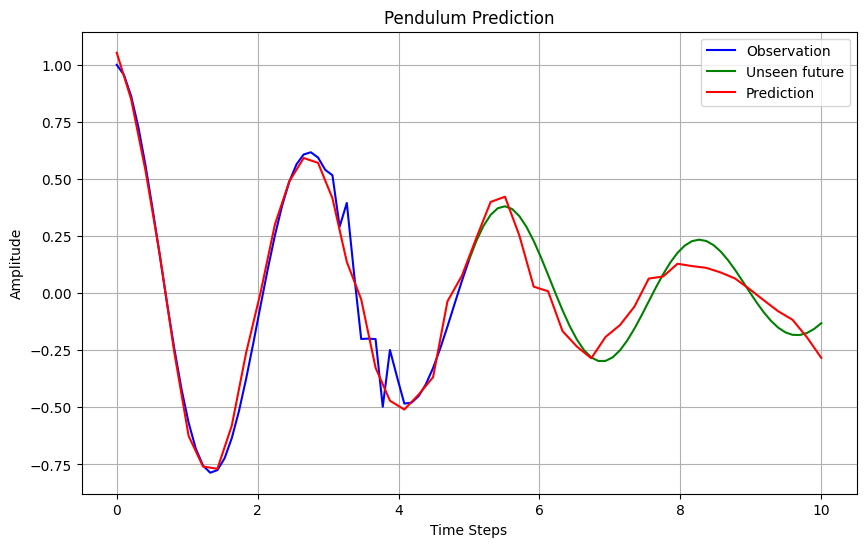

In [291]:
# Noisy data

N_samples = 1
observations, _, _, params = build_dataset(N_samples, config.KAPA_RANGE, config.B_RANGE)
observation_noisy = create_one_anomaly(observations[0], 'noise', seed=None, start_index=30, duration=10,intensity=0.3)[0]
answers = data_synthetic_pendulum(params[0][0], params[0][1], t=np.linspace(config.MAXTIME, config.MAXTIME*2, config.TIMESTEPS))

questions = np.linspace(0, config.MAXTIME*2, config.TIMESTEPS)
possible_answers = make_timeserie_prediction(pendulum_net, observation_noisy, questions, device=device)
plot_timeserie_prediction(observation_noisy, answers, possible_answers, maxtime=config.MAXTIME, timesteps=config.TIMESTEPS)

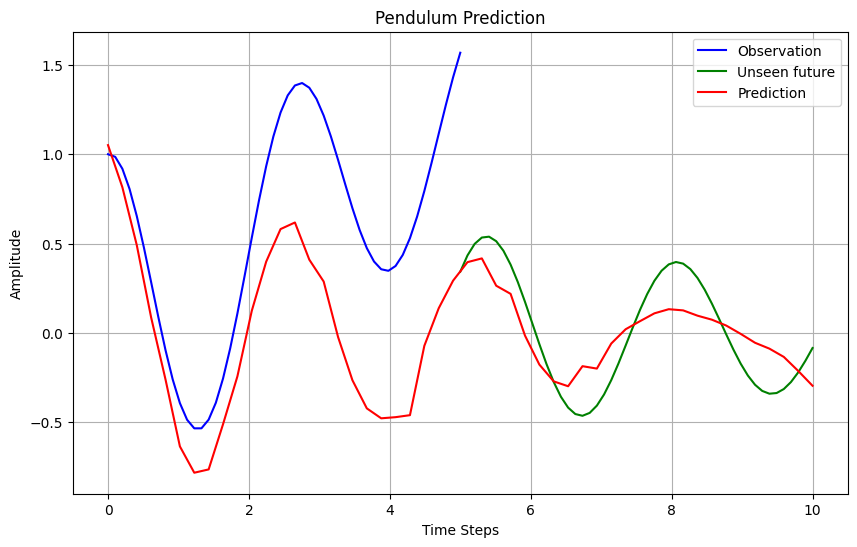

In [292]:
# Drifted data

N_samples = 1
observations, _, _, params = build_dataset(N_samples, config.KAPA_RANGE, config.B_RANGE)
observation_drifted = create_one_anomaly(observations[0], 'drift+overflow', seed=None, slope=0.025, value_upper=None, value_lower=None)[0]
answers = data_synthetic_pendulum(params[0][0], params[0][1], t=np.linspace(config.MAXTIME, config.MAXTIME*2, config.TIMESTEPS))

questions = np.linspace(0, config.MAXTIME*2, config.TIMESTEPS)
possible_answers = make_timeserie_prediction(pendulum_net, observation_drifted, questions, device=device)
plot_timeserie_prediction(observation_drifted, answers, possible_answers, maxtime=config.MAXTIME, timesteps=config.TIMESTEPS)

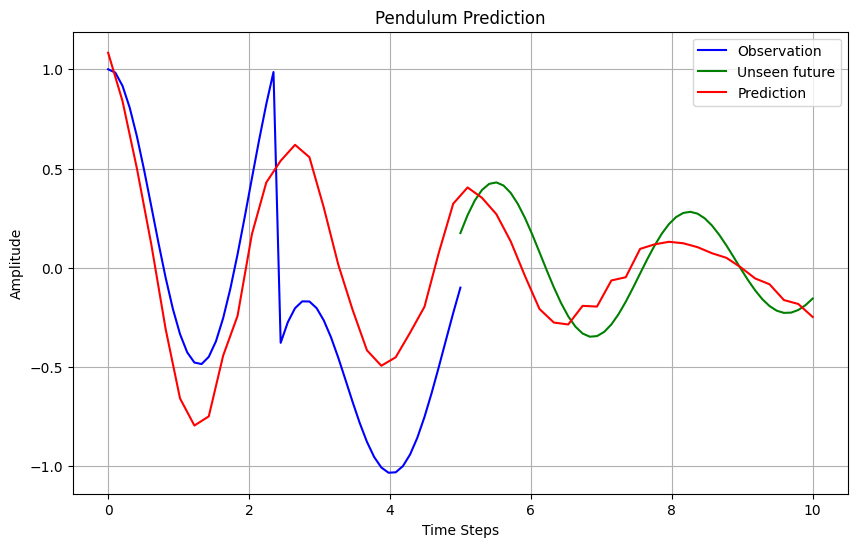

In [293]:
# Drifted data with overflow

N_samples = 1
observations, _, _, params = build_dataset(N_samples, config.KAPA_RANGE, config.B_RANGE)
observation_drifted_overflow = create_one_anomaly(observations[0], 'drift+overflow', seed=None, slope=0.025, value_upper=1.1, value_lower=-0.4)[0]
answers = data_synthetic_pendulum(params[0][0], params[0][1], t=np.linspace(config.MAXTIME, config.MAXTIME*2, config.TIMESTEPS))

questions = np.linspace(0, config.MAXTIME*2, config.TIMESTEPS)
possible_answers = make_timeserie_prediction(pendulum_net, observation_drifted_overflow, questions, device=device)
plot_timeserie_prediction(observation_drifted_overflow, answers, possible_answers, maxtime=config.MAXTIME, timesteps=config.TIMESTEPS)

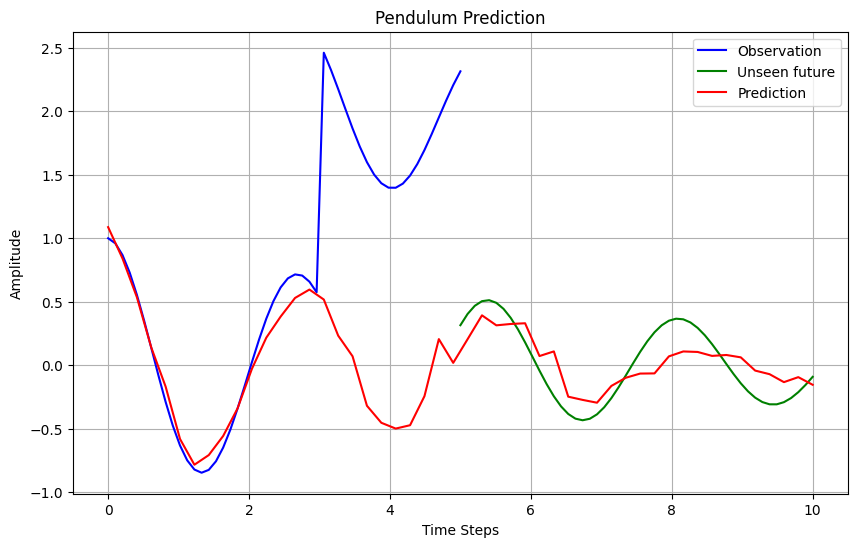

In [294]:
# Shifted data

N_samples = 1
observations, _, _, params = build_dataset(N_samples, config.KAPA_RANGE, config.B_RANGE)
observation_shifted = create_one_anomaly(observations[0], 'level_shift', seed=None, start_index=30, shift_value=2)[0]
answers = data_synthetic_pendulum(params[0][0], params[0][1], t=np.linspace(config.MAXTIME, config.MAXTIME*2, config.TIMESTEPS))

questions = np.linspace(0, config.MAXTIME*2, config.TIMESTEPS)
possible_answers = make_timeserie_prediction(pendulum_net, observation_shifted, questions, device=device)
plot_timeserie_prediction(observation_shifted, answers, possible_answers, maxtime=config.MAXTIME, timesteps=config.TIMESTEPS)

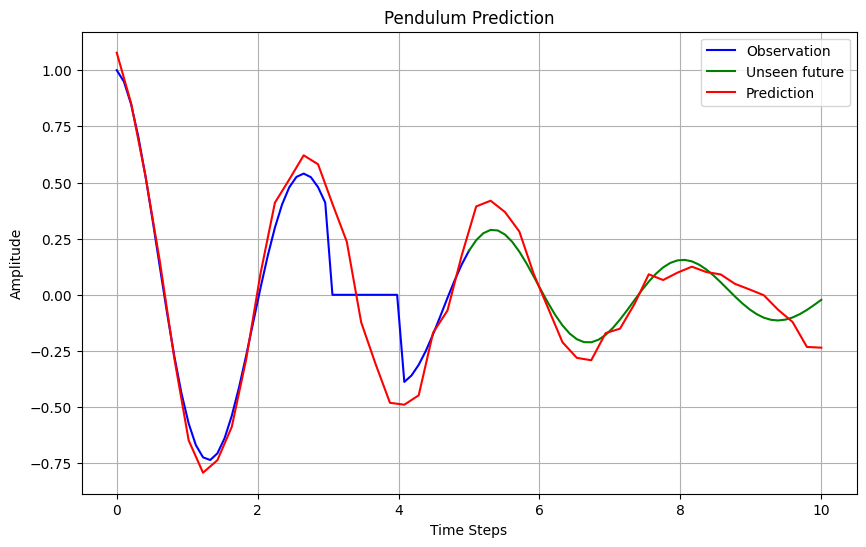

In [295]:
# Broken seasonality data

N_samples = 1
observations, _, _, params = build_dataset(N_samples, config.KAPA_RANGE, config.B_RANGE)
observation_broken = create_one_anomaly(observations[0], 'seasonal_break', seed=None, start_index=30, duration=10)[0]
answers = data_synthetic_pendulum(params[0][0], params[0][1], t=np.linspace(config.MAXTIME, config.MAXTIME*2, config.TIMESTEPS))

questions = np.linspace(0, config.MAXTIME*2, config.TIMESTEPS)
possible_answers = make_timeserie_prediction(pendulum_net, observation_broken, questions, device=device)
plot_timeserie_prediction(observation_broken, answers, possible_answers, maxtime=config.MAXTIME, timesteps=config.TIMESTEPS)